# Report task 2: Machine Learning

## Introduction

## The Dataset

Read data (source: https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame)

Because the data has no headers included, I will create these myself

supervised want labels aanwezig


In [40]:
import pandas as pd
feature_cols=[
    "top-left", "top-middle", "top-right", 
    "middle-left", "middle-middel", "middle-right", 
    "bottom-left", "bottom-middle", "bottom-right", 
    
    ]
tictactoe_df = pd.read_csv("data/tic-tac-toe.data",
                           sep=',',
                           header=None, 
                           names=feature_cols+["x has won"]
                           )
                           
tictactoe_df

,top-left,top-middle,top-right,middle-left,middle-middel,middle-right,bottom-left,bottom-middle,bottom-right,x has won
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


### Exploratory Data Analysis


kijk data na, minimum requerements berijkt?

In [41]:
print(tictactoe_df.describe())
print(tictactoe_df.isna().sum())

       top-left top-middle top-right middle-left middle-middel middle-right  \
count       958        958       958         958           958          958   
unique        3          3         3           3             3            3   
top           x          x         x           x             x            x   
freq        418        378       418         378           458          378   

       bottom-left bottom-middle bottom-right x has won  
count          958           958          958       958  
unique           3             3            3         2  
top              x             x            x  positive  
freq           418           378          418       626  
top-left         0
top-middle       0
top-right        0
middle-left      0
middle-middel    0
middle-right     0
bottom-left      0
bottom-middle    0
bottom-right     0
x has won        0
dtype: int64


unbalanced features:

We see that x (first player) is in all locations on the board more used than b (other player). This is normal because when x wins, he has had 1 turn more than b. And when b wins, they had the same amount of wins. So it is normal that x occurs more.

In [42]:
for column in tictactoe_df.columns:
    value_counts = tictactoe_df[column].value_counts()
    print(f"Counts for {column}:\n{value_counts}\n")

Counts for top-left:
top-left
x    418
o    335
b    205
Name: count, dtype: int64

Counts for top-middle:
top-middle
x    378
o    330
b    250
Name: count, dtype: int64

Counts for top-right:
top-right
x    418
o    335
b    205
Name: count, dtype: int64

Counts for middle-left:
middle-left
x    378
o    330
b    250
Name: count, dtype: int64

Counts for middle-middel:
middle-middel
x    458
o    340
b    160
Name: count, dtype: int64

Counts for middle-right:
middle-right
x    378
o    330
b    250
Name: count, dtype: int64

Counts for bottom-left:
bottom-left
x    418
o    335
b    205
Name: count, dtype: int64

Counts for bottom-middle:
bottom-middle
x    378
o    330
b    250
Name: count, dtype: int64

Counts for bottom-right:
bottom-right
x    418
o    335
b    205
Name: count, dtype: int64

Counts for x has won:
x has won
positive    626
negative    332
Name: count, dtype: int64



### Splitting the data

split data in training set and testing set

In [43]:
from sklearn.model_selection import train_test_split

X = tictactoe_df[feature_cols] # Features
y = tictactoe_df[['x has won']] # target variable
  

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

#### encoding

Because the data in the features are strings, I need to encode the data. This encoding is necessary because Scikit requires the values to be floats. This encoding gives a numeric value the different string categories. This can be done in different ways. 2 of the most often used encoding methods are Label Encoding and One Hot Encoding. 

Label encoding gives each categorical value of a feature a numerical value. If there are 3 different categorical values, these will be encoded to [1,2,3]. This encoding method is requires not much computational power. But it will create an order in the data.

One Hot Encoding will generate a new column for each categorical value in a feature. In each column there will be 2 possible values, 0 and 1. 0 means the item does not have the specific value of that column.  1 means the item does have the specific value of that column. This will create more variables and it requires a lot more computational power. 

Our data is not nominal ["o", "x", "b"], there is no certain order. This hints that One Hot Encoding will be better for this dataset. That is why I will use One Hot Encoding.

In [44]:
import category_encoders as ce

# label encoding
# ce_ord = ce.OrdinalEncoder(cols = feature_cols)
# X_train_cat = ce_ord.fit_transform(X_train)
# X_test_cat = ce_ord.fit_transform(X_test)

# hot encoding
ce_oh = ce.OneHotEncoder(cols = feature_cols)
X_train_cat_oh = ce_oh.fit_transform(X_train)
X_test_cat_oh = ce_oh.fit_transform(X_test)
print(X_train_cat_oh)

     top-left_1  top-left_2  top-left_3  top-middle_1  top-middle_2  \
169           1           0           0             1             0   
577           0           1           0             1             0   
601           0           1           0             0             1   
851           0           0           1             0             1   
868           0           0           1             0             1   
..          ...         ...         ...           ...           ...   
637           1           0           0             0             0   
370           0           0           1             1             0   
213           1           0           0             1             0   
842           0           0           1             1             0   
513           0           1           0             0             0   

     top-middle_3  top-right_1  top-right_2  top-right_3  middle-left_1  ...  \
169             0            1            0            0           

## Baseline

In [45]:
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier



from sklearn.metrics import confusion_matrix
from sklearn import metrics

from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

create model (kies entropy of gini zoek op wat het verschil is tussen de 2)

In [46]:
clf_baseline = DecisionTreeClassifier(criterion = "entropy")
clf_baseline = clf_baseline.fit(X_train_cat_oh, y_train)

teken decision tree

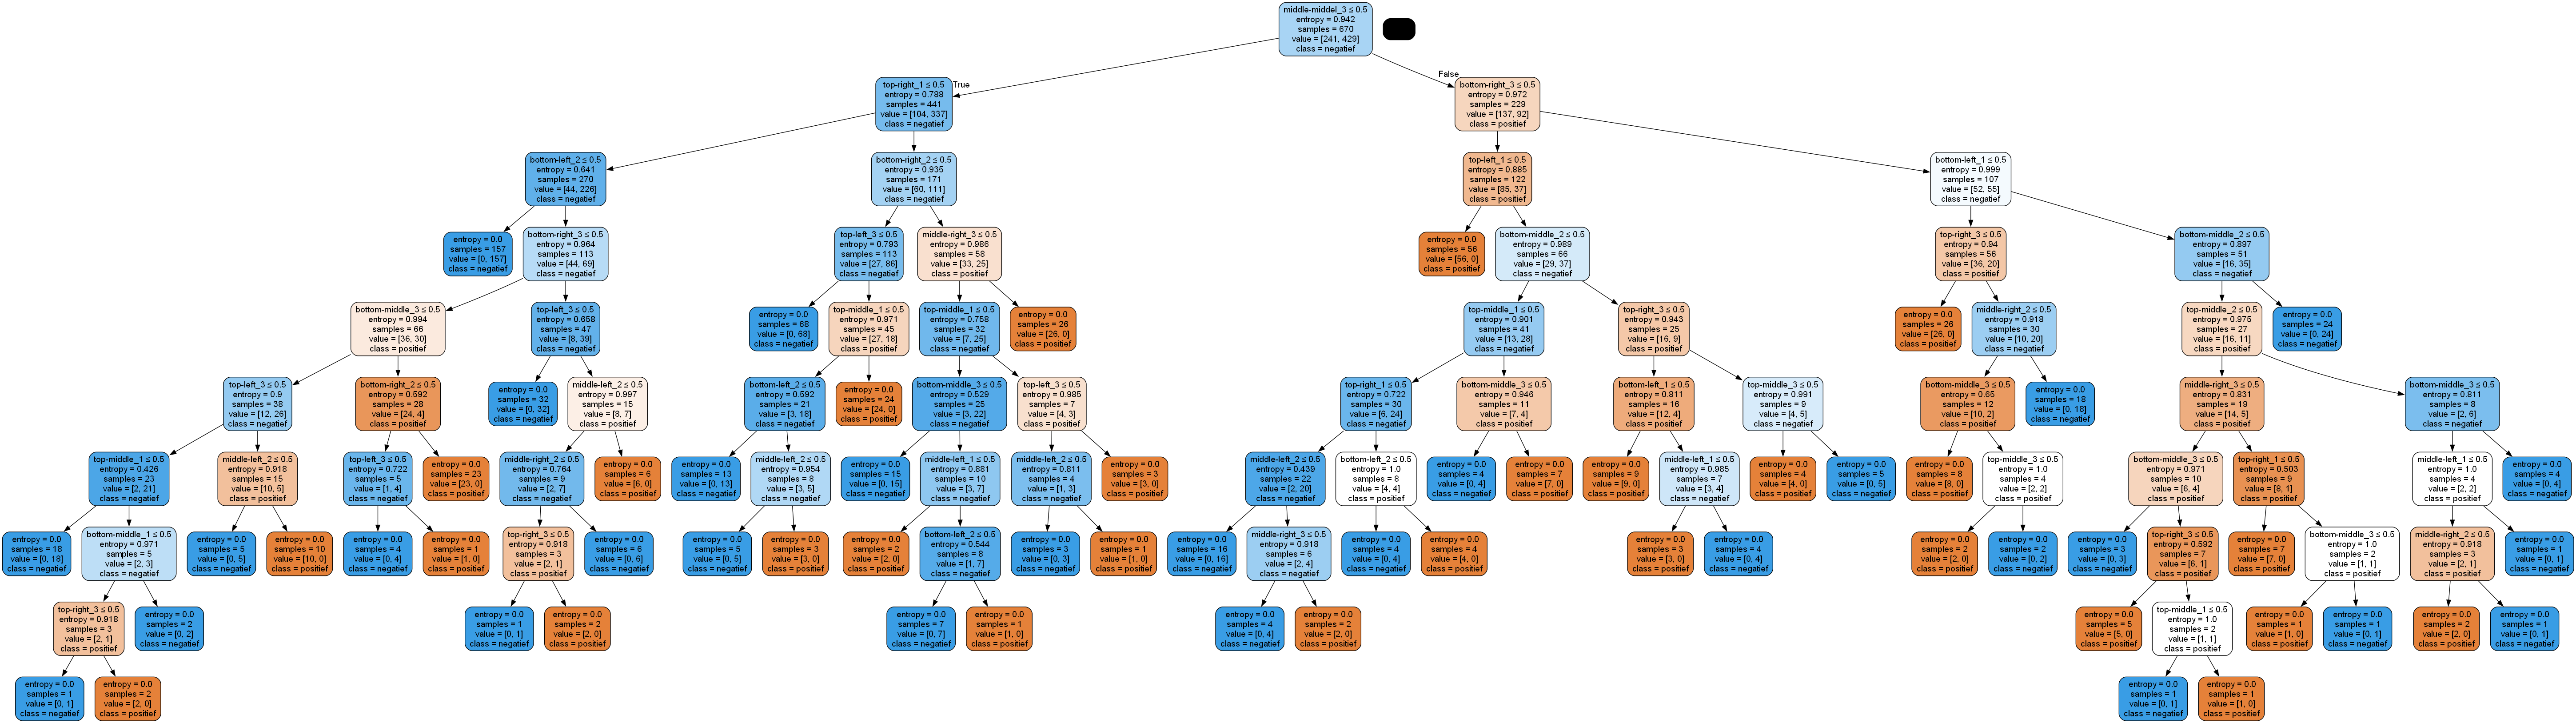

In [47]:
dot_data = StringIO()
export_graphviz(clf_baseline, 
                out_file = dot_data, 
                filled = True, 
                rounded = True,
                special_characters = True, 
                feature_names = X_train_cat_oh.columns, 
                class_names=['positief', 'negatief']
                )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=2000)

predictions

In [56]:
y_pred_baseline = clf_baseline.predict(X_test_cat_oh)

confusion matrix

Because I want to collect information about the model. I want to show the confusion matrix and calculate the accuracy. We want this for the models we will after the baseline model as well, so we will create a function that prints the information we want to see.

First we create and print the confusion matrix. Because the diagonal from the upper left has all the correct predictions, we can easily sum these up to get the amount of correct predictions. We can also calculate the total amount of predictions we have made. At last we can also calculate the accuracy.

In [63]:
def print_confusion(actual, prediction):

    confusion = confusion_matrix(actual, prediction, labels = ["positive", "negative"])
    print(f"Confusion matrix: \n{confusion}")

    # Good predictions: 
    correct_predictions = confusion.diagonal().sum()
    print(f"Amount of correct predictions: {correct_predictions}")

    # Total number:
    total_predictions = confusion.sum()
    print(f"Total amount of predictions: {total_predictions}")

    # Accuracy:
    print(f"Accuracy: {correct_predictions/total_predictions}")
    # Ook mogelijk voor accuracy: print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

Now we can use this function with out the outcomes of the test dataset and the predictions my model has made.

In [64]:
print_confusion(y_test, y_pred_baseline)

Confusion matrix: 
[[145  52]
 [ 67  24]]
Amount of correct predictions: 169
Total amount of predictions: 288
Accuracy: 0.5868055555555556


## Gaussian Naive Bayes

In [62]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
clf_gnb= gnb.fit(X_train_cat_oh, y_train)
y_pred_gnb = clf_gnb.predict(X_test_cat_oh)
print_confusion(y_test, y_pred_gnb)

Confusion matrix: 
[[149  48]
 [ 66  25]]
Amount of correct predictions: 174
Total amount of predictions: 288
Accuracy: 0.6041666666666666


c:\Users\rafen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


bronnen:


https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/#:~:text=Label%20encoding%20is%20simpler%20and,lead%20to%20high-dimensional%20data.

https://www.statology.org/label-encoding-vs-one-hot-encoding/

https://scikit-learn.org/stable/modules/naive_bayes.html